Earlier this year I did a [blog post on "Generalized substructure search"](https://greglandrum.github.io/rdkit-blog/tutorial/substructure/2021/08/03/generalized-substructure-search.html) with the RDKit. That demonstrated how to use some advanced query features like link nodes, variable attachment points, and tautomer insensitivity to search through the compounds from ChEMBL 29 with the RDKit's `SubstructLibrary`.

This post uses the same ChEMBL 29 `SubstructLibrary` to demonstrate a couple of new features which were added in the 2021.09 release of the RDKit:
1. Changing the search order
2. Specifying which compounds are actually searched
3. Saving a molecule key (or name) together with the molecules in the `SubstructLibrary`

For more about the `SubstructLibrary`, take a look at this earlier post about [generalized substructure search](https://greglandrum.github.io/rdkit-blog/tutorial/substructure/2021/08/03/generalized-substructure-search.html).

In [1]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import rdSubstructLibrary
from rdkit import RDLogger
from rdkit import rdBase
import pickle
import time
import gzip
print(rdBase.rdkitVersion)
print(time.asctime())

2021.09.3
Mon Dec 20 05:14:01 2021


Here's the code to build the `SubstructLibrary` from the sdf file distributed by the ChEMBL team. 
This uses a feature added in RDKit v2021.09 to allow a molecule key (or name) to be stored with the molecules in a `SubstructLibrary`.

Executing this takes about 45 minutes on my machine.

We're going to use the number of heavy atoms to determine the search order. Since that takes a while, go ahead and pre-calculate those values and store them in the same pickle file as the SubstructLibrary:

Read in the saved data:

In [2]:
with open('./results/chembl29_ssslib.pkl','rb') as inf:
    slib = pickle.load(inf)
    nat_order = pickle.load(inf)


Here's the query we'll use for this post:

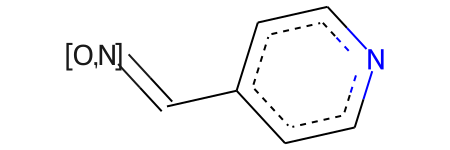

In [3]:
qry = Chem.MolFromSmarts('[O,N]=C-c:1:c:c:n:c:c:1')
qry

Let's look at doing a search. We also take advantage of the `SubstructLibrary`'s `KeyHolder` (a new feature in v2021.09) to include the compound ChEMBL IDs in the results:

1000 results


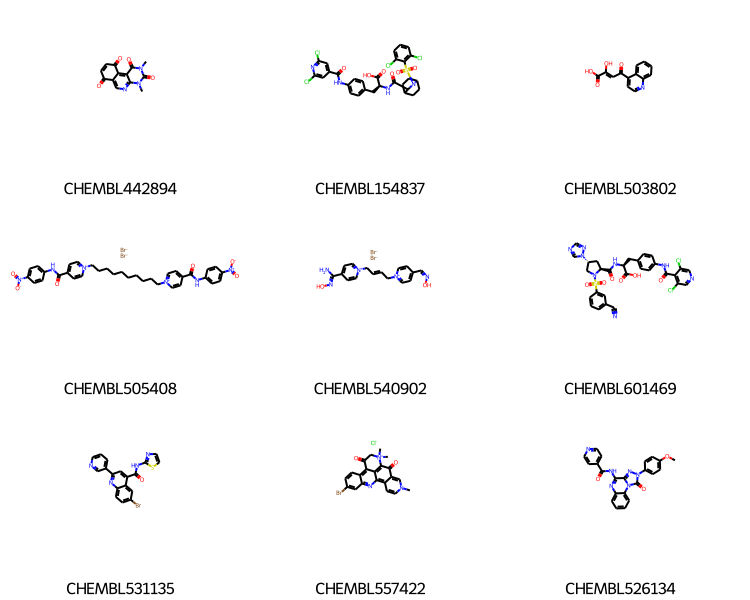

In [4]:
mids = slib.GetMatches(qry)
print(f'{len(mids)} results')
ms = [slib.GetMolHolder().GetMol(x) for x in mids[:9]]
legends = [slib.GetKeyHolder().GetKey(x) for x in mids[:9]]
Draw.MolsToGridImage(ms,legends=legends,subImgSize=(250,200))

One of the new features is that we can change the search order; this allows us to get the smallest molecules first (always a good idea with a substructure search). 

Here we're using the number of heavy atoms to set the search order:

1000 results


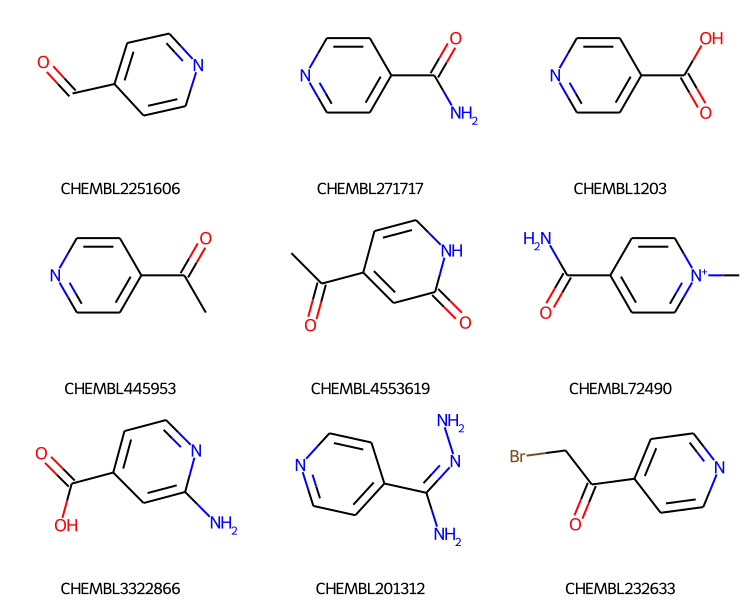

In [5]:
slib.SetSearchOrder(nat_order)
mids = slib.GetMatches(qry)
print(f'{len(mids)} results')
ms = [slib.GetMolHolder().GetMol(x) for x in mids[:9]]
legends = [slib.GetKeyHolder().GetKey(x) for x in mids[:9]]
Draw.MolsToGridImage(ms,legends=legends,subImgSize=(250,200))

It's important to note that we are not just sorting the results from the search here: we're changing the order in which the search is done. So even though we're only getting 1000 results (the default max number of results from the SubstructLibrary), we know that they are the 1000 smallest results.

So if we change the maximum number of results to three, we'll get the same first three results:

3 results


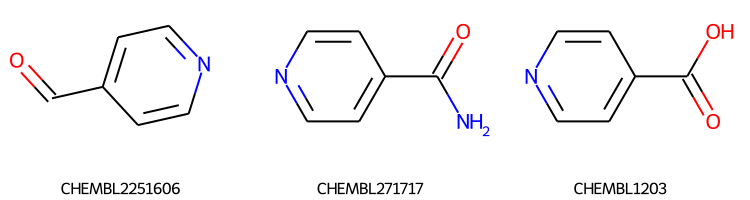

In [6]:
slib.SetSearchOrder(nat_order)
mids2 = slib.GetMatches(qry,maxResults=3)
print(f'{len(mids2)} results')
ms = [slib.GetMolHolder().GetMol(x) for x in mids2[:9]]
legends = [slib.GetKeyHolder().GetKey(x) for x in mids2[:9]]
Draw.MolsToGridImage(ms,legends=legends,subImgSize=(250,200))

We can also use the search order to limit the compounds we search. In this case I'm going to refine the results of the previous search and identify compounds which also contain Br:

66 sub-results


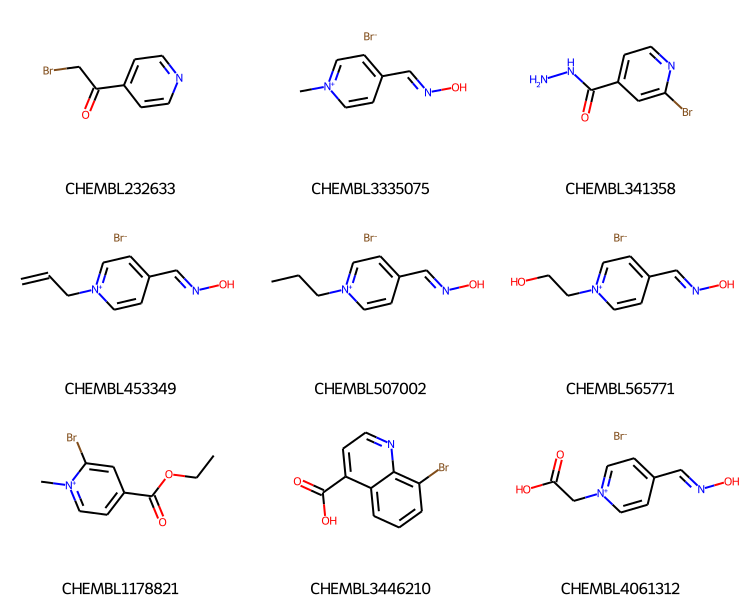

In [7]:
slib.SetSearchOrder(mids)
mids_new = slib.GetMatches(Chem.MolFromSmarts('[Br]'))
print(f'{len(mids_new)} sub-results')
ms = [slib.GetMolHolder().GetMol(x) for x in mids_new[:9]]
legends = [slib.GetKeyHolder().GetKey(x) for x in mids_new[:9]]
Draw.MolsToGridImage(ms,legends=legends,subImgSize=(250,200))

Notice that the results are still coming back sorted by the number of heavy atoms. That's because the IDs of the molecules being used for the search search is sorted.

We almost certainly ran up against the default limit on the number of results (1000 compounds) when doing the first search. Let's loosen that to 50K. This will take longer since the first query ends up having to run through the entire database.

In [8]:
slib.SetSearchOrder(nat_order)
mids = slib.GetMatches(qry,maxResults=50000)
print(f'{len(mids)} results')

slib.SetSearchOrder(mids)
mids_new = slib.GetMatches(Chem.MolFromSmarts('[Br]'))
print(f'{len(mids_new)} sub-results')


17764 results
919 sub-results


It's never a bad idea to check the performance of these queries.

Here's the run time for the default value of `maxResults`:

In [9]:
slib.SetSearchOrder(nat_order)
%timeit mids = slib.GetMatches(qry)


71.7 ms ± 710 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


And here's the search time for going through the entire database (we only get 17K results here, so maxResults=50K corresponds to searching through the entire database):

In [10]:
slib.SetSearchOrder(nat_order)
%timeit mids = slib.GetMatches(qry,maxResults=50000)


5.09 s ± 79.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
